In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity

In [24]:
df_dw = pd.read_excel("dw_dominate_data/dw_dominate_house.XLSX")
df_dw = df_dw[['Congress Number', 'Party Code', '1st Dimension Coordinate', '1st Dimension Bootstrapped Standard Error']]
df_dw['Party Code'] = pd.to_numeric(df_dw['Party Code'], errors='coerce')

#filtering out other parties
#100 = Democrats,  200 = Republicans
df_dw = df_dw[df_dw['Party Code'].isin([100, 200])]

#Group by party and congress and calculate average 1_dimension
df_dw["abs_d1"] = df_dw["1st Dimension Coordinate"].abs()
party_avgs = (
    df_dw.groupby(["Congress Number", "Party Code"])          # one group = one party in one Congress
    .agg(avg_abs_d1=("abs_d1", "mean"))                  # rename the column for clarity
    .reset_index()
)

mask = party_avgs["Party Code"].eq(party_avgs["Party Code"].shift(-1))
#congress where only ona party avg is available
congress_same_party = party_avgs.loc[mask, "Congress Number"].tolist()

# keep the rows where the condition is **False**
df_kept = party_avgs.loc[~mask].reset_index(drop=True)
df_kept[df_kept["Congress Number"].between(75, 112)]

# --- Apply Party-Seat Weighting ---
df_seats_partition = pd.read_excel("dw_dominate_data/house_seats.xlsx")
df_seats_partition = df_seats_partition[["Congress Number", "# Seats", "Democrats", "Republicans"]]
df_seats_partition = df_seats_partition[df_seats_partition["Congress Number"].between(76, 111)]

# df1 and df2 each have a column called "Congress Number"
df_merged = pd.merge(
    df_kept,                       # left table
    df_seats_partition,                       # right table
    on="Congress Number",      # key column present in *both* tables
    how="inner",               # match-type: inner | left | right | outer
    suffixes=("_x", "_y")      # handles duplicate column names
)

df_merged["Weighted 1-dimension"] = np.where(
    df_merged["Party Code"] == 100,                      # condition
    df_merged["avg_abs_d1"] * df_merged["Democrats"]   / df_merged["# Seats"],   # if Democrat
    df_merged["avg_abs_d1"] * df_merged["Republicans"] / df_merged["# Seats"]    # if Republican
)

# sum the weighted scores within each (Congress, Party) pair
weighted_sum = (
    df_merged.groupby(["Congress Number"], as_index=False)
    ["Weighted 1-dimension"]
    .sum()
    .rename(columns={"Weighted 1-dimension": "weighted_sum"})
)

weighted_sum = weighted_sum.sort_values("Congress Number")

Standardization

In [25]:
#standardization of df-dominate score
array_score = np.array(weighted_sum["weighted_sum"])

score_std = np.std(array_score)
score_mean = np.mean(array_score)

standard_dw_score = (array_score - score_mean)/score_std
standard_dw_score = standard_dw_score.tolist()

Model accuracy lines

In [26]:
models = ["bayes", "lr", "svm"]
base_dir = Path("models_avg_results")
standardize_accuracy = []

for model in models:
    model_file = base_dir / f"tfidf_{model}_performance_avg.csv"
    df = pd.read_csv(model_file)
    accuracy_scores = df["accuracy"]
    accuracy_array = np.array(accuracy_scores)
    accuracy_std = np.std(accuracy_array)
    accuracy_mean = np.mean(accuracy_array)
    
    standard_accuracy_score = (accuracy_array - accuracy_mean)/accuracy_std 
    print(len(standard_accuracy_score))
    standardize_accuracy.append(standard_accuracy_score)

print(standardize_accuracy)

36
36
36
[array([-1.86366527, -0.4127547 , -1.21343958, -0.76584237, -0.11334845,
       -0.732575  , -0.76811059, -1.4689934 , -1.57181979, -1.32760711,
       -0.09973908, -0.29253855, -0.4671922 ,  0.08398748, -0.31824515,
       -0.14359151, -0.33563491,  0.13918106, -0.40595001, -0.25624689,
        0.13842498, -0.55414098,  0.50058557,  0.69111682, -0.32429376,
       -0.5087764 ,  0.0514762 ,  1.23624789,  1.51902045,  0.27678696,
        0.53082862,  0.91415935,  1.77457427,  1.9976168 ,  1.99534857,
        2.09515065]), array([-1.69231856, -0.74152813, -1.53585938, -1.04040529, -0.31628009,
       -0.78565764, -0.86254998, -1.87151113, -1.24099399, -1.1467173 ,
       -0.04882849, -0.32497227, -0.30157025,  0.30621351,  0.14173077,
        0.21929174, -0.35439194,  0.25740359, -0.25342896,  0.12635231,
        0.38109996, -0.28686041,  0.19120932,  0.06951884, -0.26546428,
       -0.46137258,  0.22397214,  0.88858936,  1.35194926,  0.23868198,
        0.52752971,  0.44461971,

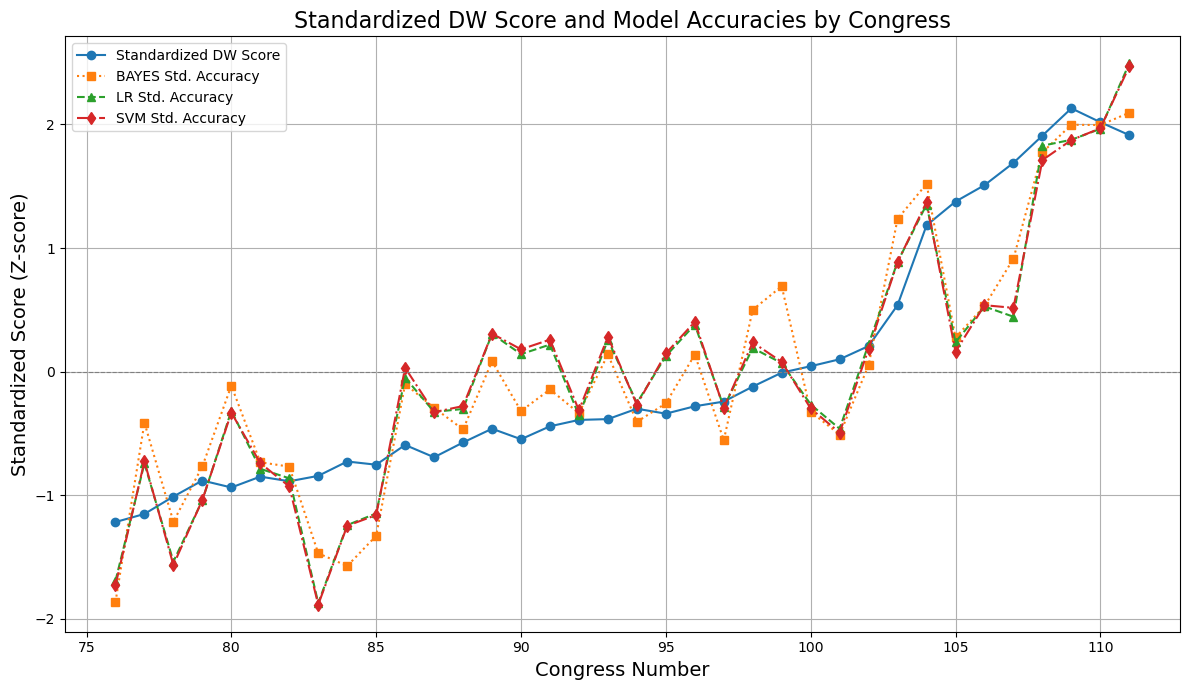

In [20]:
plt.figure(figsize=(12, 7))  # Adjusted size for better readability with multiple lines

# Plot the standardized DW score
plt.plot(
    weighted_sum["Congress Number"],
    standard_dw_score,
    marker="o",
    linestyle="-", # Solid line for DW score
    label="Standardized DW Score"  # Label for the legend
)

# Define some distinct markers and linestyles for the models
model_markers = ['s', '^', 'd']  # square, triangle_up, diamond
model_linestyles = [':', '--', '-.'] # dotted, dashed, dash-dot

# Plot the standardized accuracy for each model
for i, model_name in enumerate(models):
    if i < len(standardize_accuracy): # Check if accuracy data exists for this model index
        model_acc_scores = standardize_accuracy[i]
        plt.plot(
            weighted_sum["Congress Number"],
            model_acc_scores,
            marker=model_markers[i % len(model_markers)], # Cycle through markers
            linestyle=model_linestyles[i % len(model_linestyles)], # Cycle through linestyles
            label=f"{model_name.upper()} Std. Accuracy"  # Label for the legend
        )
    else:
        print(f"Warning: Missing accuracy data for model index {i} ({model_name}). Skipping plot for this model.")


plt.xlabel("Congress Number", fontsize=14)
plt.ylabel("Standardized Score (Z-score)", fontsize=14) # General Y-axis label
plt.title("Standardized DW Score and Model Accuracies by Congress", fontsize=16) # Updated title

plt.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Reference line at Z-score = 0

plt.legend()  # Add the legend to the plot
plt.grid(True)
plt.tight_layout()
plt.show()

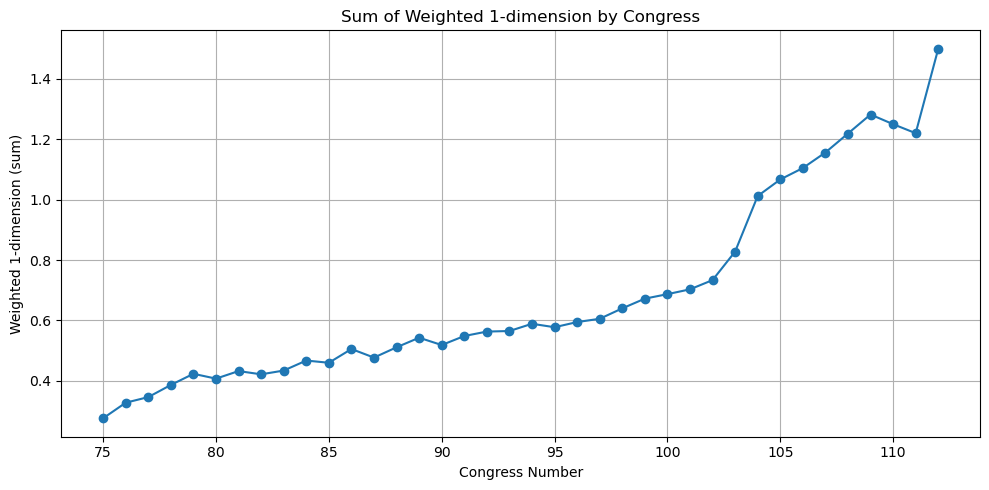

In [21]:

plt.figure(figsize=(10, 5))               # a comfortable size
plt.plot(
    weighted_sum["Congress Number"],
    standard_dw_score,
    marker="o"                            # dots help show each Congress
)                                         # (no explicit color → Matplotlib default)

plt.xlabel("Congress Number")
plt.ylabel("Weighted 1-dimension (sum)")
plt.title("Sum of Weighted 1-dimension by Congress")
plt.grid(True)                            # light background grid
plt.tight_layout()                        # tidy margins
plt.show()

# Cosing similarity

=== COSINE SIMILARITY RESULTS (Manual) ===
DW Score vs BAYES: 0.8692
DW Score vs LR: 0.8539
DW Score vs SVM: 0.8468

=== COSINE SIMILARITY RESULTS (sklearn) ===
DW Score vs BAYES: 0.8692
DW Score vs LR: 0.8539
DW Score vs SVM: 0.8468

=== SIMILARITY RANKING ===
1. BAYES: 0.8692
2. LR: 0.8539
3. SVM: 0.8468

=== INTERPRETATION ===
BAYES: Very Strong similarity (Same direction) - 0.8692
LR: Very Strong similarity (Same direction) - 0.8539
SVM: Very Strong similarity (Same direction) - 0.8468

=== SUMMARY TABLE ===
Model  Cosine_Similarity  Rank
BAYES           0.869158     1
   LR           0.853876     2
  SVM           0.846845     3


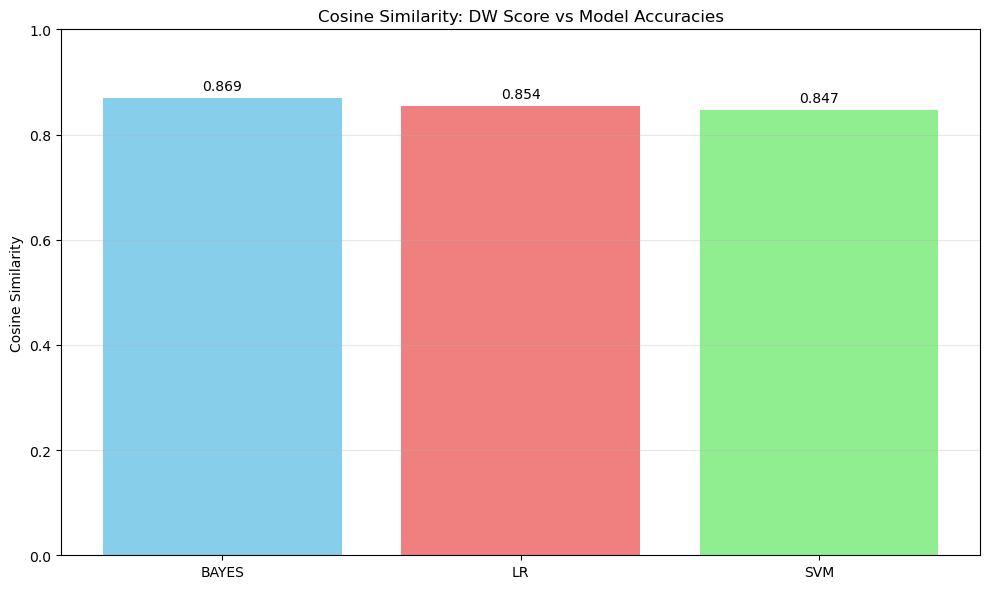


Highest similarity: 0.8692
Lowest similarity: 0.8468
Range: 0.0223


In [27]:
# =============================================================================
# COSINE SIMILARITY IMPLEMENTATION
# =============================================================================

def calculate_cosine_similarity_manual(series1, series2):
    """
    Calculate cosine similarity manually between two time series
    """
    # Convert to numpy arrays
    a = np.array(series1)
    b = np.array(series2)
    
    # Calculate dot product
    dot_product = np.dot(a, b)
    
    # Calculate magnitudes (norms)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    
    # Calculate cosine similarity
    cosine_sim = dot_product / (norm_a * norm_b)
    
    return cosine_sim

# Method 1: Manual calculation
print("=== COSINE SIMILARITY RESULTS (Manual) ===")
cosine_results_manual = {}

for i, model in enumerate(models):
    similarity = calculate_cosine_similarity_manual(standard_dw_score, standardize_accuracy[i])
    cosine_results_manual[model] = similarity
    print(f"DW Score vs {model.upper()}: {similarity:.4f}")

print("\n" + "="*50)

# Method 2: Using sklearn (alternative approach)
print("=== COSINE SIMILARITY RESULTS (sklearn) ===")

# Reshape for sklearn (needs 2D arrays)
dw_score_2d = np.array(standard_dw_score).reshape(1, -1)
cosine_results_sklearn = {}

for i, model in enumerate(models):
    accuracy_2d = standardize_accuracy[i].reshape(1, -1)
    similarity = cosine_similarity(dw_score_2d, accuracy_2d)[0][0]
    cosine_results_sklearn[model] = similarity
    print(f"DW Score vs {model.upper()}: {similarity:.4f}")

print("\n" + "="*50)

# =============================================================================
# RESULTS ANALYSIS
# =============================================================================

print("=== SIMILARITY RANKING ===")
# Sort models by similarity (highest first)
sorted_models = sorted(cosine_results_manual.items(), key=lambda x: x[1], reverse=True)

for rank, (model, similarity) in enumerate(sorted_models, 1):
    print(f"{rank}. {model.upper()}: {similarity:.4f}")

print("\n=== INTERPRETATION ===")
for model, similarity in cosine_results_manual.items():
    if similarity > 0.8:
        strength = "Very Strong"
    elif similarity > 0.6:
        strength = "Strong"
    elif similarity > 0.4:
        strength = "Moderate"
    elif similarity > 0.2:
        strength = "Weak"
    else:
        strength = "Very Weak"
    
    direction = "Same direction" if similarity > 0 else "Opposite direction"
    print(f"{model.upper()}: {strength} similarity ({direction}) - {similarity:.4f}")

# =============================================================================
# CREATE SUMMARY DATAFRAME
# =============================================================================

summary_df = pd.DataFrame({
    'Model': [model.upper() for model in models],
    'Cosine_Similarity': [cosine_results_manual[model] for model in models],
    'Rank': range(1, len(models) + 1)
})

# Sort by similarity
summary_df = summary_df.sort_values('Cosine_Similarity', ascending=False).reset_index(drop=True)
summary_df['Rank'] = range(1, len(summary_df) + 1)

print("\n=== SUMMARY TABLE ===")
print(summary_df.to_string(index=False))

# =============================================================================
# OPTIONAL: VISUALIZE SIMILARITIES
# =============================================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
models_upper = [model.upper() for model in models]
similarities = [cosine_results_manual[model] for model in models]

bars = plt.bar(models_upper, similarities, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity: DW Score vs Model Accuracies')
plt.ylim(0, 1)

# Add value labels on bars
for bar, sim in zip(bars, similarities):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{sim:.3f}', ha='center', va='bottom')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nHighest similarity: {max(similarities):.4f}")
print(f"Lowest similarity: {min(similarities):.4f}")
print(f"Range: {max(similarities) - min(similarities):.4f}")